In [3]:
import xarray
import pandas

In [4]:
import utils.compound as compound
import utils.timePeriod as tp
from helpers.fileHandler import to_365day_monthly 
%run helpers/impactPlots.ipynb

# Load AGCD gridded precip data

In [3]:
prPaths = !find /g/data/zv2/agcd/v2/precip/total/r005/01month

In [4]:
prPaths[0:5]

['/g/data/zv2/agcd/v2/precip/total/r005/01month',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1915.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1965.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1918.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1902.nc']

Need to drop index 0:

In [5]:
#load the files, use cftime becuase I use cftime everywhere
prXr=xarray.open_mfdataset(prPaths[1:], use_cftime=True).precip

In [6]:
prXr

<xarray.DataArray 'precip' (time: 1445, lat: 691, lon: 886)>
dask.array<concatenate, shape=(1445, 691, 886), dtype=float32, chunksize=(12, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1900-01-16 00:00:00 ... 2020-05-16 00:00:00
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Attributes:
    cell_methods:           time: sum time: sum (interval : 1 day)
    units:                  mm
    long_name:              Daily precipitation
    standard_name:          lwe_thickness_of_precipitation_amount
    frequency:              monthly
    start_offset:           -24
    grid_mapping:           crs
    coverage_content_type:  physicalMeasurement
    valid_range:            [     0. 100000.]

The precipitatio field is the sum of the daily rainfall for each month:

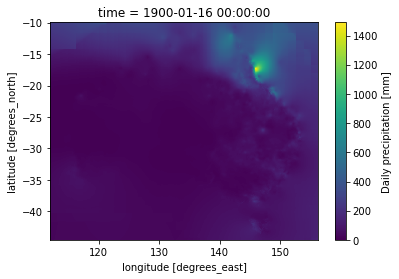

In [7]:
prXr.isel(time=0).plot()

So lets scale that:

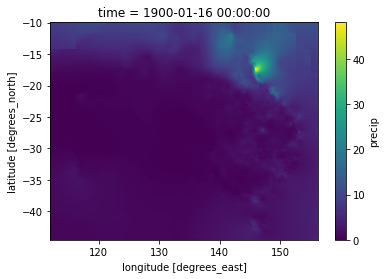

In [8]:
prXr=(prXr/prXr.time.dt.days_in_month)
prXr.name='precip'
prXr.isel(time=0).plot()

In [9]:
prXr

<xarray.DataArray 'precip' (time: 1445, lat: 691, lon: 886)>
dask.array<truediv, shape=(1445, 691, 886), dtype=float64, chunksize=(12, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1900-01-16 00:00:00 ... 2020-05-16 00:00:00
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2

# and temp

In [10]:
tPaths = !find /g/data/zv2/agcd/v1/tmax/mean/r005/01month

In [11]:
tXr=xarray.open_mfdataset(tPaths[1:], use_cftime=True).tmax

In [12]:
tXr

<xarray.DataArray 'tmax' (time: 1325, lat: 691, lon: 886)>
dask.array<concatenate, shape=(1325, 691, 886), dtype=float32, chunksize=(12, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1910-01-16 00:00:00 ... 2020-05-16 00:00:00
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Attributes:
    cell_methods:               time: maximum time: mean (interval : 1 day)
    units:                      degrees_Celsius
    analysis_version_number:    2.0
    long_name:                  Daily maximum air temperature
    standard_name:              air_temperature
    frequency:                  monthly
    length_scale_for_analysis:  350.0
    end_offset:                 24
    grid_mapping:               crs
    coverage_content_type:      physicalMeasurement
    valid_range:                [-100.  100.]

# Process them into anomalies, and calculate warm season avs

In [13]:
prTXr=xarray.merge([
    prXr,
    tXr
])

prTXr=to_365day_monthly(prTXr) #Use 365 calendar for consistency with everything else

In [14]:
#climatXr=prTXr.where(prTXr.time.dt.year<1930)
climatXr=prTXr

prTAnomsXr=prTXr.groupby('time.month')-climatXr.groupby('time.month').mean('time')
prTAnomsXr=prTAnomsXr.rename({'tmax':'tsAnom','precip':'precAnom'})

In [15]:
prTAnomsXr=prTAnomsXr.chunk({'time':'auto','lat':100,'lon':100}) #chunk so there is only one chunk along the time axis

In [16]:
prTAnomsXr

<xarray.Dataset>
Dimensions:   (lat: 691, lon: 886, time: 1445)
Coordinates:
  * time      (time) object 1900-01-16 00:00:00 ... 2020-05-16 00:00:00
  * lat       (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon       (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
    month     (time) int64 dask.array<chunksize=(1445,), meta=np.ndarray>
Data variables:
    precAnom  (time, lat, lon) float64 dask.array<chunksize=(1445, 100, 100), meta=np.ndarray>
    tsAnom    (time, lat, lon) float32 dask.array<chunksize=(1445, 100, 100), meta=np.ndarray>

In [17]:
prTWarmSeasonXr=tp.averageForTimePeriod(prTAnomsXr)

In [18]:
prTWarmSeasonXr.to_netcdf('results/observPrTmaxAnoms.nc')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


# and the reconstructions

Xarray doesn't load direct from CSV but Pandas does:

In [19]:
iodPd=pandas.read_csv('ref/abram2020/abram2020-iod-event.txt', sep='	', header=135, index_col=0)
iodPd

,July-Dec-anom,30-y-stdev,pIOD-events,epIOD-events,Unnamed: 5
Year,,,,,
1240,NaN,5.110536,0.0,0.0,NaN
1241,-0.605520,10.436320,0.0,0.0,NaN
1242,-0.143572,8.061502,0.0,0.0,NaN
1243,0.573652,4.840072,0.0,0.0,NaN
1244,0.497826,2.580668,0.0,0.0,NaN
...,...,...,...,...,...
2015,1.534088,24.583960,1.0,0.0,NaN
2016,-1.668266,27.976240,0.0,0.0,NaN
2017,0.620306,28.902430,0.0,0.0,NaN


As I don't know how to use pandas, im just going to turn that into an xr

In [20]:
iodXr=iodPd.to_xarray()

iodXr=iodXr.rename({'Year ':'year'})

In [21]:
indexXr=xarray.Dataset()

indexXr['dmi']=iodXr['July-Dec-anom'].sel(year=range(1900,2006))

indexXr

<xarray.Dataset>
Dimensions:  (year: 106)
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Data variables:
    dmi      (year) float64 -1.003 -1.043 0.6172 ... 0.5767 0.234 -0.9248

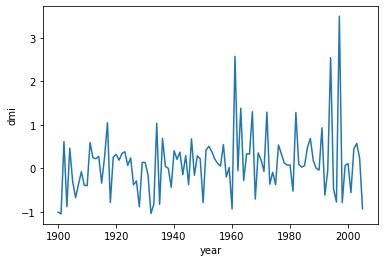

In [22]:
indexXr.dmi.plot()

In [23]:
samPd=pandas.read_csv('ref/fogt/recons_mean7100.txt', index_col=0, sep=' +', na_values=-999.900)

samPd

<ipython-input-23-255e97c9cb03>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  samPd=pandas.read_csv('ref/fogt/recons_mean7100.txt', index_col=0, sep=' +', na_values=-999.900)


,DJF,MAM,JJA,SON
1865,0.088,-1.740,NaN,NaN
1866,0.937,0.726,NaN,NaN
1867,-2.675,1.564,NaN,NaN
1868,-1.724,-0.246,NaN,NaN
1869,-2.429,-0.649,NaN,NaN
...,...,...,...,...
2001,1.015,1.686,1.583,1.485
2002,1.657,-0.943,-1.933,-3.352
2003,0.139,2.644,1.767,-0.555
2004,-0.488,1.072,0.018,-0.047


In [24]:
samXr=samPd.to_xarray()

In [25]:
samXr=samXr.rename({'index':'year'}).sel(year=range(1900,2006))

In [26]:
samXr

<xarray.Dataset>
Dimensions:  (year: 106)
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Data variables:
    DJF      (year) float64 0.119 -2.468 -2.457 -0.444 ... 0.139 -0.488 nan
    MAM      (year) float64 -0.46 -1.014 -1.835 -1.464 ... 2.644 1.072 0.983
    JJA      (year) float64 nan nan nan nan nan ... -1.933 1.767 0.018 -0.047
    SON      (year) float64 nan nan nan nan nan ... -3.352 -0.555 -0.047 -0.848

In [27]:
#going to use the spring/summer average (i.e. warm season)

indexXr['sam']=samXr[['SON','DJF']].to_array().mean('variable')

In [28]:
indexXr

<xarray.Dataset>
Dimensions:  (year: 106)
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Data variables:
    dmi      (year) float64 -1.003 -1.043 0.6172 ... 0.5767 0.234 -0.9248
    sam      (year) float64 0.119 -2.468 -2.457 -0.444 ... -0.208 -0.2675 -0.848

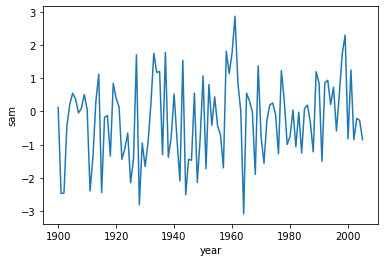

In [29]:
indexXr.sam.plot()

In [30]:
ensoPd=pandas.read_csv('ref/freund2019Enso/freund2019enso.txt',sep='	', header=105, index_col=0)
ensoPd

,Season,NCT,NWP
age_CE,,,
1617,3,0.150,0.035
1617,6,-0.344,-0.081
1617,9,-0.300,-0.071
1617,12,-0.182,-0.043
1618,3,-0.098,-0.023
...,...,...,...
2007,3,0.101,0.001
2007,6,0.200,0.013
2007,9,0.134,0.004


In [31]:
ensoXr=ensoPd.to_xarray()

ensoXr=ensoXr.rename({'age_CE':'year'})

In [32]:
# winter-spring-summer average
ensoReducedXr=(
    ensoXr.where(ensoXr.Season==6, drop=True)
    +ensoXr.where(ensoXr.Season==9, drop=True)
    +ensoXr.where(ensoXr.Season==12, drop=True)
)/3

In [33]:
ensoReducedXr=ensoReducedXr.drop('Season').sel(year=range(1900,2006))

In [34]:
ensoReducedXr

<xarray.Dataset>
Dimensions:  (year: 106)
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Data variables:
    NCT      (year) float64 -0.2337 -0.3247 0.6963 ... 0.06 0.09933 -0.2323
    NWP      (year) float64 0.106 0.03567 0.259 ... 0.04833 0.003667 -0.049

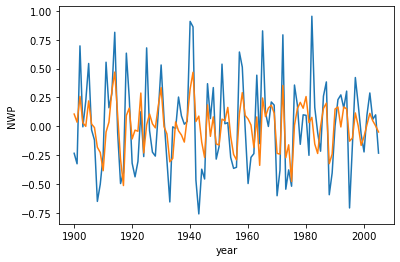

In [35]:
ensoReducedXr.NCT.plot()
ensoReducedXr.NWP.plot()

Merge those three Xrs together

In [36]:
indexXr=xarray.merge([
    indexXr,
    ensoReducedXr
])

In [37]:
indexXr

<xarray.Dataset>
Dimensions:  (year: 106)
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Data variables:
    dmi      (year) float64 -1.003 -1.043 0.6172 ... 0.5767 0.234 -0.9248
    sam      (year) float64 0.119 -2.468 -2.457 -0.444 ... -0.208 -0.2675 -0.848
    NCT      (year) float64 -0.2337 -0.3247 0.6963 ... 0.06 0.09933 -0.2323
    NWP      (year) float64 0.106 0.03567 0.259 ... 0.04833 0.003667 -0.049

# Now, set some criteria to determine events

Per normal, 1 sigma for enso/iod. 0.5 sigma for SAM.

However, we don't have a good baseline period. Lets choose 1900-1930 (somewhat arbitrary?)

In [38]:
stdXr=indexXr.sel(year=range(1900,1930)).std()

In [39]:
criteriaXr=stdXr
criteriaXr['sam']=stdXr.sam/2

In [40]:
criteriaXr

<xarray.Dataset>
Dimensions:  ()
Data variables:
    dmi      float64 0.5256
    sam      float64 0.5974
    NCT      float64 0.3978
    NWP      float64 0.2046

In [41]:
firePosXr, fireNegXr = compound.applyCriteria(indexXr, criteriaXr)

firePos: 
['NCT', 'dmi', 'NWP']
fireNeg: 
['sam']


In [42]:
firePosXr

<xarray.Dataset>
Dimensions:  (year: 106)
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Data variables:
    NCT      (year) float64 0.0 0.0 1.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    dmi      (year) float64 0.0 0.0 1.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0 0.0 0.0
    NWP      (year) float64 0.0 0.0 1.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    sam      (year) float64 0.0 1.0 1.0 0.0 0.0 0.0 ... 1.0 0.0 1.0 0.0 0.0 1.0

In [62]:
firePosXr['ecCombined']=firePosXr[['NCT','NWP']].to_array().any('variable')
fireNegXr['ecCombined']=fireNegXr[['NCT','NWP']].to_array().any('variable')

In [63]:
eventsXr=xarray.concat(
    [
        firePosXr,
        fireNegXr
    ],
    'fire')

eventsXr['fire']=['pos','neg']

In [64]:
eventsXr.to_netcdf('results/reconstructEvents.nc')

# If we plot some impact maps now, do they look plausible?

In [5]:
eventsXr=xarray.load_dataset('results/reconstructEvents.nc')

In [6]:
prTWarmSeasonXr = xarray.load_dataset('results/observPrTmaxAnoms.nc')

In [7]:
eventsLs = ['NCT', 'NWP', 'ENSO', 'dmi', 'sam', ]

In [8]:
prTWarmSeasonXr

<xarray.Dataset>
Dimensions:   (lat: 691, lon: 886, year: 120)
Coordinates:
  * lat       (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon       (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * year      (year) int64 1900 1901 1902 1903 1904 ... 2015 2016 2017 2018 2019
Data variables:
    precAnom  (year, lat, lon) float64 0.0004444 0.000446 ... -0.06793 -0.06802
    tsAnom    (year, lat, lon) float32 nan nan nan ... 0.04326 0.04448 0.04579

# Anoms for indiv indices - Fire Pos

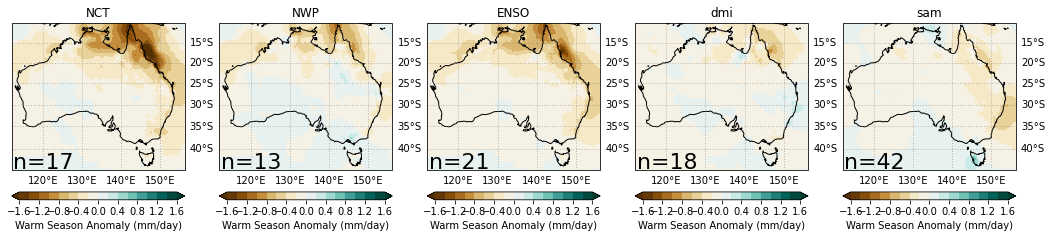

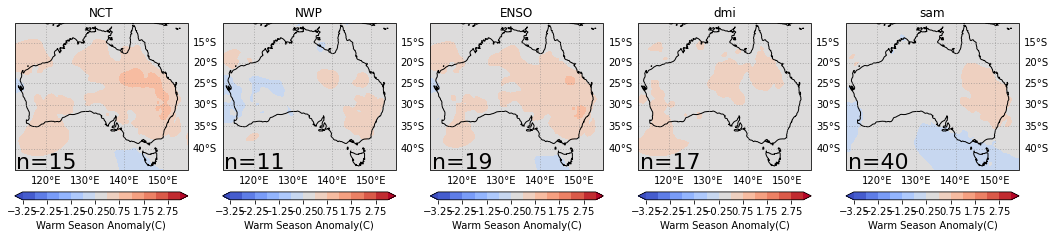

In [95]:
indexPlotter(prTWarmSeasonXr.precAnom, eventsXr.sel(fire='pos'), eventsLs)
plt.show()

indexPlotter(prTWarmSeasonXr.tsAnom, eventsXr.sel(fire='pos'), eventsLs)

NCT is cool tongue (EP)

NWP is warm pool (CP)

The result above might be skewed a bit by the correlation between NCT and NWP. So lets look at NWP (not NCT) only too:

In [16]:
nwpOnlyXr=xarray.merge([
    eventsXr.NWP,
    eventsXr.NCT==0
]).to_array().all('variable').to_dataset(name='nwpOnly')

In [17]:
nwpOnlyXr

<xarray.Dataset>
Dimensions:  (fire: 2, year: 106)
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
  * fire     (fire) object 'pos' 'neg'
Data variables:
    nwpOnly  (fire, year) bool False False False False ... False False False

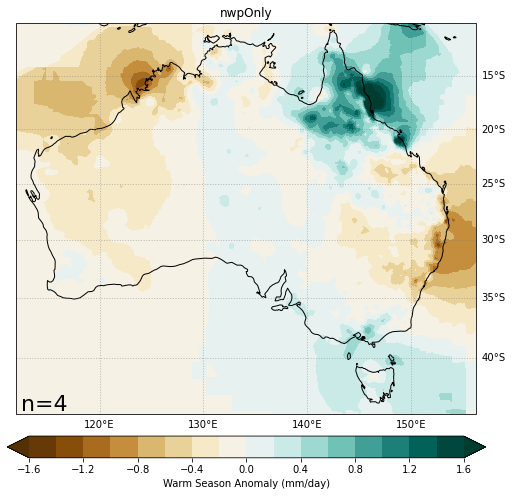

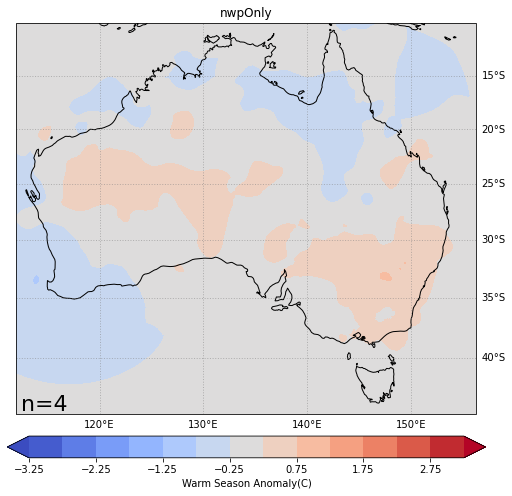

In [19]:
indexPlotter(prTWarmSeasonXr.precAnom, nwpOnlyXr.sel(fire='pos'), ['nwpOnly'])
plt.show()

indexPlotter(prTWarmSeasonXr.tsAnom, nwpOnlyXr.sel(fire='pos'), ['nwpOnly'])

# Anoms for indiv indices - Fire Neg

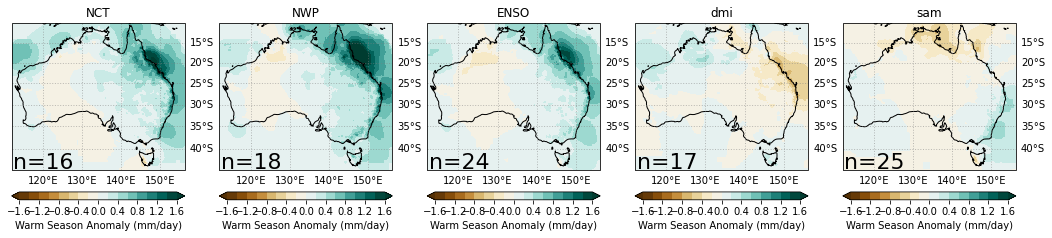

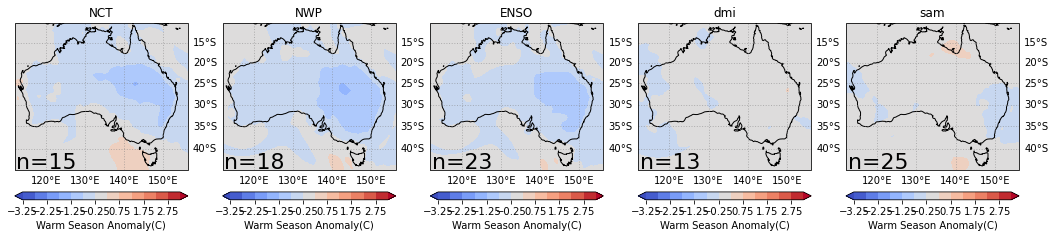

In [96]:
indexPlotter(prTWarmSeasonXr.precAnom, eventsXr.sel(fire='neg'), eventsLs)
plt.show()

indexPlotter(prTWarmSeasonXr.tsAnom, eventsXr.sel(fire='neg'), eventsLs)

# Compound them and see what happens

In [65]:
compoundEventsXr=compound.compound(eventsXr)

ecCombinedDmiSam
NCTDmiSam
NWPDmiSam


In [72]:
compoundEventsXr.ecCombinedDmiSam.to_dataset('compound')

<xarray.Dataset>
Dimensions:      (fire: 2, year: 106)
Coordinates:
  * year         (year) int64 1900 1901 1902 1903 1904 ... 2002 2003 2004 2005
  * fire         (fire) <U3 'pos' 'neg'
Data variables:
    nEvents      (fire, year) float64 0.0 1.0 3.0 0.0 0.0 ... 0.0 0.0 0.0 1.0
    all3         (fire, year) float64 0.0 0.0 1.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    enso+iod     (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    enso+sam     (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iod+sam      (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    enso         (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iod          (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0
    sam          (fire, year) float64 0.0 1.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    anyCompound  (fire, year) float64 0.0 0.0 1.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [68]:
compoundEventsLs=[*compoundEventsXr.pairs, 'all3']

In [103]:
compoundEventsXr['ecCombinedDmiSam'].sel(fire='pos', drop=True).to_dataset('compound')

<xarray.Dataset>
Dimensions:      (year: 106)
Coordinates:
  * year         (year) int64 1900 1901 1902 1903 1904 ... 2002 2003 2004 2005
Data variables:
    nEvents      (year) float64 0.0 1.0 3.0 0.0 0.0 1.0 ... 0.0 1.0 1.0 0.0 1.0
    all3         (year) float64 0.0 0.0 1.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    enso+iod     (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    enso+sam     (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    iod+sam      (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    enso         (year) float64 0.0 0.0 0.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    iod          (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 1.0 0.0 0.0
    sam          (year) float64 0.0 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 1.0
    anyCompound  (year) float64 0.0 0.0 1.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

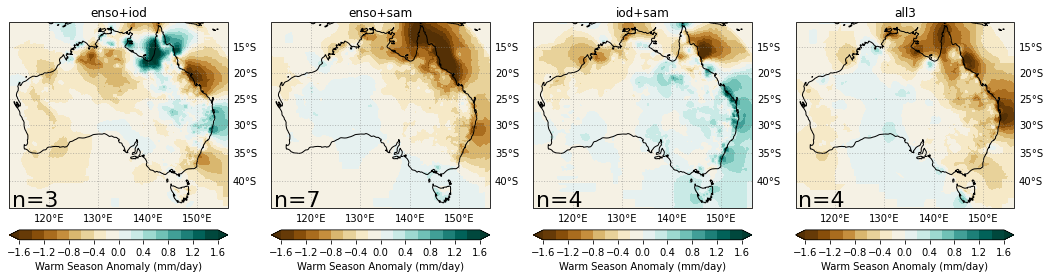

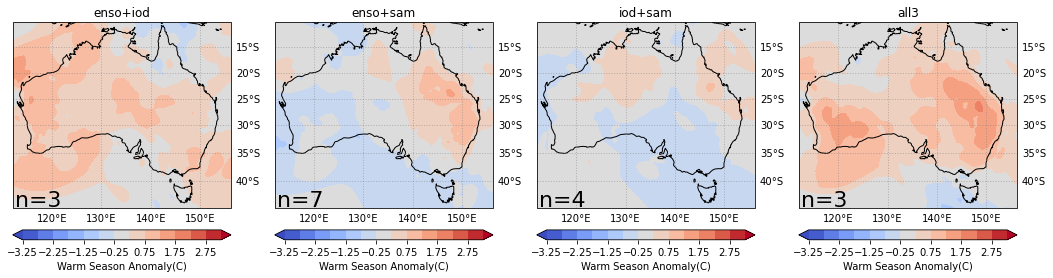

In [105]:
indexPlotter(
    prTWarmSeasonXr.precAnom, 
    compoundEventsXr['ecCombinedDmiSam'].sel(fire='pos', drop=True).to_dataset('compound'), 
    compoundEventsLs
)
plt.show()

indexPlotter(
    prTWarmSeasonXr.tsAnom, 
    compoundEventsXr['ecCombinedDmiSam'].sel(fire='pos', drop=True).to_dataset('compound'), 
    compoundEventsLs
)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


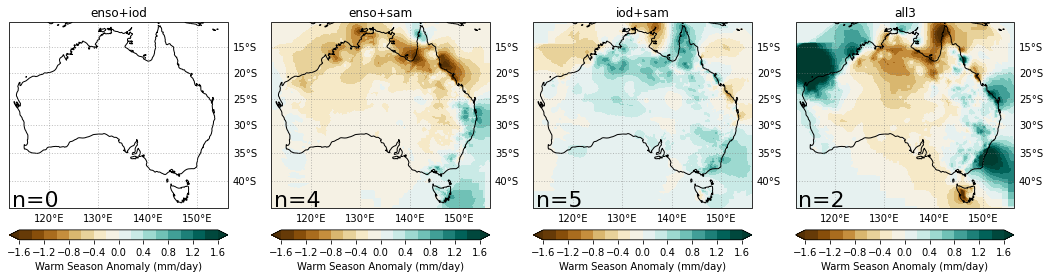

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


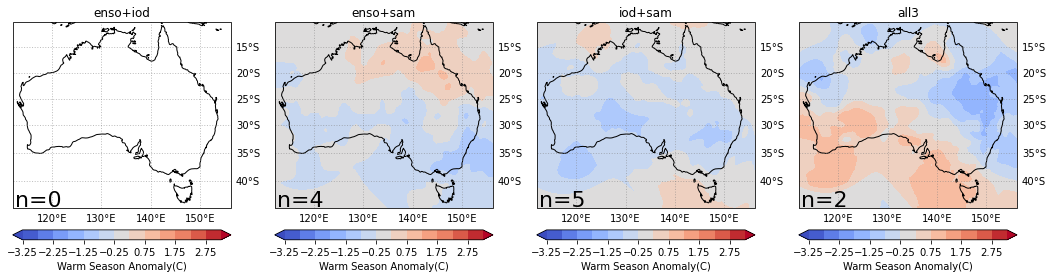

In [106]:
indexPlotter(
    prTWarmSeasonXr.precAnom, 
    compoundEventsXr['ecCombinedDmiSam'].sel(fire='neg', drop=True).to_dataset('compound'), 
    compoundEventsLs
)
plt.show()

indexPlotter(
    prTWarmSeasonXr.tsAnom, 
    compoundEventsXr['ecCombinedDmiSam'].sel(fire='neg', drop=True).to_dataset('compound'), 
    compoundEventsLs
)

# And comparison between the three enso indices

In [116]:
ensoIodEventsXr=compoundEventsXr.sel(compound='enso+iod', drop=True)

In [117]:
ensoIodEventsLs=list(ensoIodEventsXr.data_vars)

In [118]:
ensoIodEventsLs

['ecCombinedDmiSam', 'NCTDmiSam', 'NWPDmiSam']

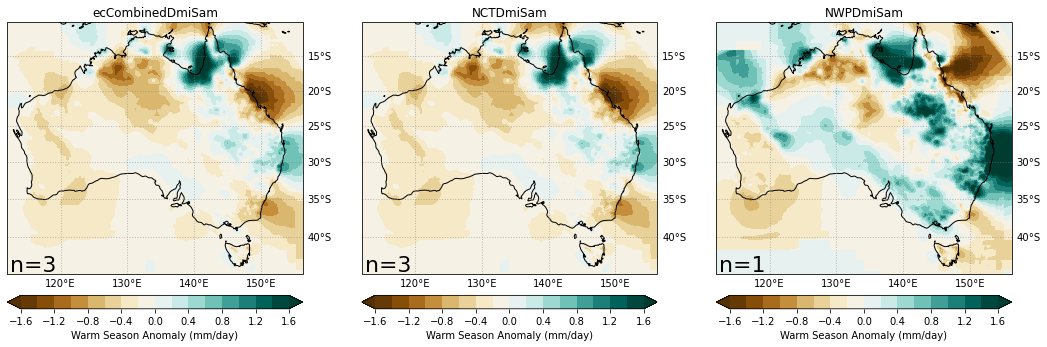

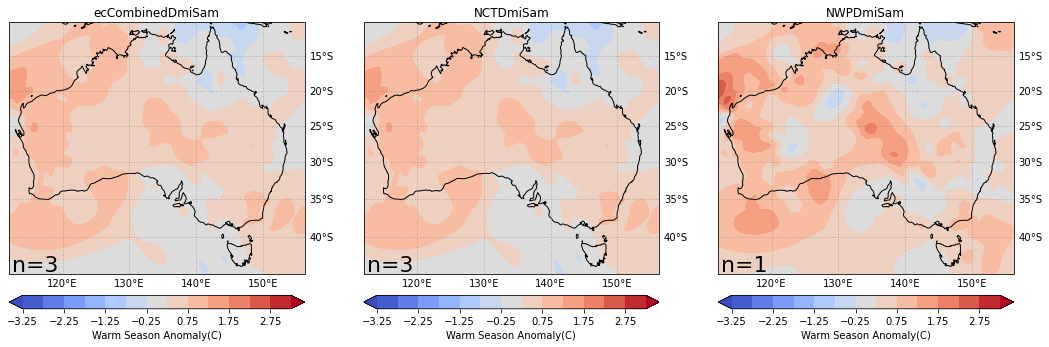

In [119]:
indexPlotter(
    prTWarmSeasonXr.precAnom, 
    ensoIodEventsXr.sel(fire='pos'), 
    ensoIodEventsLs
)
plt.show()

indexPlotter(
    prTWarmSeasonXr.tsAnom, 
    ensoIodEventsXr.sel(fire='pos'), 
    ensoIodEventsLs
)

n=0 for fire Neg Case